## Imports

In [1]:
from pymongo import MongoClient
client = MongoClient()
db = client.structure_sets

from IPython.display import display
import pandas as pd
pd.options.display.max_rows = 9999

from pymatgen import Element, Structure
from bson.objectid import ObjectId
import math
import time
import pprint
import math
import warnings
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

from matminer.figrecipes.plotly.make_plots import PlotlyFig

### Set up parallel processing units

In [144]:
import ipyparallel as ipp
c = ipp.Client()
print c.ids
# dview = c[:]
lview = c.load_balanced_view()

[0, 1, 2, 3]


## Define functions

### Define the volume predictor

In [77]:
def predict_volume(inp):
    doc = inp[0]
    bonds = inp[1]
    # hacky, had to do this to use parallel engines
    # to run code on the engines, need to pass everything (imports, variables, functions, etc) required to run
    
    """
    Given a Structure (in dict form) and a dictionary of bond length predictions,
    returns a volume prediction and data about which bond was used.
    
    Args:
        doc (dict) : a dictionary corresponding to a Structure (generated via Structure.as_dict())
        bonds (dict) : a dictionary containing bonds with their predicted lengths
                            
    Returns:
        a dictionary containing the following keys:
        name (str) : structure's reduced formula
        actual_volume (float) : volume in the structure dict
        predicted_volume (float) : volume prediction
        num_atoms (int) : number of atoms in the structure
        worst_predicted_bond (str) : ex. 'Al-F' in alphabtical order
        actual_distance (float) : actual distance for the worst_predicted_bond
        expected_distance (float) : predicted distance for the worst_predicted_bond
        _id (ObjectId) : id of the dictionary in mongodb (useful for quick retrievals/deletes/updates)
    """
    
    
    import numpy as np
    from matminer.descriptors.composition_features import get_pymatgen_descriptor
    from pymatgen import Element, Structure
    import warnings
    structure = Structure.from_dict(doc)
    cutoff=4
    ionic_factor = 0.30
    
    smallest_dist = None
    smallest_expected_dist = None
    smallest_ratio = None
    smallest_e1 = None
    smallest_e2 = None
    
    ionic_mix = min(np.std(get_pymatgen_descriptor(structure.composition, 'X')) * ionic_factor, 1)
    
    for site in structure:
        el1 = site.specie

        if el1.atomic_radius:
            r1 = el1.average_ionic_radius * ionic_mix + \
                 el1.atomic_radius * (1-ionic_mix) if el1.average_ionic_radius else el1.atomic_radius
                
            neighbors = structure.get_neighbors(site, el1.atomic_radius + cutoff)
            
            for site2, dist in neighbors:
                el2 = site2.specie
                

                if el2.atomic_radius:
                    r2 = el2.average_ionic_radius * ionic_mix + \
                         el2.atomic_radius * (1-ionic_mix) if el2.average_ionic_radius else el2.atomic_radius
                
                    bond_name = '-'.join(sorted([el1.symbol, el2.symbol]))
                    if bond_name in bonds:
                        expected_dist = bonds[bond_name]['estimates'][-1]
                    else:
                        expected_dist = float(r1+r2)

                    if not smallest_ratio or dist/expected_dist < smallest_ratio:
                        smallest_dist = dist
                        smallest_expected_dist = expected_dist
                        smallest_ratio = dist/expected_dist
                        smallest_e1 = el1
                        smallest_e2 = el2
        else:
            warnings.warn("VolumePredictor: no atomic radius data for "
                          "{}".format(el1))

    if smallest_ratio is None:
        print structure.composition.reduced_formula, doc['_id'], 'FAILED'
        return {'name':structure.composition.reduced_formula, '_id':doc['_id'],
                'status': 'FAILED'}
    
    volume_factor = (1/smallest_ratio)**3
            
    return {'name': structure.composition.reduced_formula, 'actual_volume': structure.volume,
            'predicted_volume': structure.volume * volume_factor, 'num_atoms': structure.composition.num_atoms,
            'worst_predicted_bond': '-'.join(sorted([smallest_e1.symbol, smallest_e2.symbol])),
            'actual_distance': smallest_dist, 'expected_distance': smallest_expected_dist,
            '_id':doc['_id'], 'material_id':doc['material_id']}

### Functions to import previous data

In [ ]:
def import_pred_dfs(file_list):
    """
    Import prediction DataFrames based on the list of filenames given
    
    Args:
        file_list (list) : ex. ['bl_pred_df_iter_0.csv', 'bl_pred_df_iter_1.csv']
        
    Returns:
        list of DataFrames
    """
    bl_pred_dfs = []
    for f in file_list:
        df_csv = pd.read_csv(f)
        df_csv.drop('Unnamed: 0', axis=1, inplace=True)
        bl_pred_df.append(df_csv)
        
    return bl_pred_dfs


def import_bond_data(f):
    """
    Import database of bond lengths from json 
    
    Args:
        f (json) : ex. 'bonds_0.json'
        
    Returns:
        dict of bonds (see bonds)
    """
    with open(f) as data_file:    
        bonds_from_json = json.load(data_file)
    bonds = bonds_from_json
    return bonds_from_json

### Functions for initializing the bonds database (these functions run during iteration 0)

In [ ]:
def create_bonds_dict(bl_pred_df_0, bonds=bonds):
    """
    Initializes the bonds dictionary based the DataFrame corresponding to iteration 0
    """
    
    for b in bl_pred_df_0['worst_predicted_bond'].unique():
        if b not in bonds:
            bonds[b]={'mp_values':{}, 'estimates':[]}

            
def get_mp_values(c, bonds=bonds):
    """
    Given a material, adds the worst_predicted_bond to the bonds database.
    This function is run on a DataFrame:
        ex. bl_pred_dfs[i].apply(get_mp_values,axis=1)
    
    Args:
        c (Series) : Series corresponding to a single structure
    """
    
    if c['worst_predicted_bond'] in bonds:
        bonds[c['worst_predicted_bond']]['mp_values'][c['material_id']] = c['actual_distance']
    else:
        print c['worst_predicted_bond'], 'DNE. Creating entry in bonds dict..'
        bonds[c['worst_predicted_bond']]={'mp_values':{c['material_id']:c['actual_distance']}, 'estimates':[]}

### Functions to retrieve n% of the the worst bond predictions for an iteration

In [ ]:
# def get_worst_predicted_bonds_avg_minus_median():
#     bond_estimate_data = []
#     percent_to_return = 0.1
#     num_bonds_to_change = int(percent_to_return*len(bonds))
#     for b in bonds:
#         b_median = np.median(bonds[b]['mp_values'].values())
#         b_est = bonds[b]['estimates'][-1]
#         b_dist = abs(b_median-b_est)

#         bond_estimate_data.append({'bond_name':b, 'median-estimate': b_dist})

#     bond_estimate_data_df = pd.DataFrame(bond_estimate_data)

#     return bond_estimate_data_df.sort_values('median-estimate',ascending=False)[:num_bonds_to_change]['bond_name'].tolist()


def get_worst_predicted_bonds_avg_score(bl_pred_df, percent_to_return=10):
    """
    Given a dataframe corresponding to an iteration, retrieves n% of the worst performing bond
    length predictions, based on which bonds had the highest average percent error.
    
    Args:
        bl_pred_df (DataFrame) : ex. corresponds to material data
        
    Returns:
        list of worst performing bond names
    """    
    bond_estimate_data = []
    percent_to_return = float(percent_to_return)/100.0
    num_bonds_to_change = int(percent_to_return*len(bonds))
    for b in bl_pred_df['worst_predicted_bond'].unique():
        df =  bl_pred_df[bl_pred_df['worst_predicted_bond']==b]
        mean_score = df['score'].mean()
        bond_estimate_data.append({'bond_name':b, 'mean_score': np.mean(mean_score)})

    bond_estimate_data_df = pd.DataFrame(bond_estimate_data)

    return bond_estimate_data_df.sort_values('mean_score',ascending=False)[:num_bonds_to_change]['bond_name'].tolist()
    

### Update bond length estimates for a specified list of bonds

In [78]:
def update_estimates(bl_pred_df, iter_num, bonds_to_update,weight=0.5):
    """
    Given a dataframe corresponding to an iteration and a list of worst performing bonds,
    move the bond length estimates closer to the Materials Project median by a specified weight
    
    Args:
        bl_pred_df (DataFrame) : ex. corresponds to material data
        iter_num (int): the iteration number
        bonds_to_update(list): list of bond names that performed the worst
        weight(float): weight the movement from old prediction to MP median
    """   
    
    for b in bonds_to_update:
        if len(bonds[b]['estimates'])<iter_num+2: # after iter 0, want at most 2 estimate entries, 3 after iter 1, etc.
            if len(bonds[b]['estimates']) == 0: # first estimate is always the OG ionic mix prediction
                df = bl_pred_df[bl_pred_df['worst_predicted_bond']==b]
                new_estimate = df['expected_distance'].mean()
            else:
                new_estimate = weight*(np.median(bonds[b]['mp_values'].values())) + (1-weight)*(bonds[b]['estimates'][-1])
                
            bonds[b]['estimates'].append(new_estimate)
            

### Scoring functions, distance and percent error

In [220]:
def dist_df(c, pred_vol='predicted_volume', act_vol='actual_volume', num_atoms='num_atoms'):
    """
    Returns a score based on distance from the y=x line
    
    Args:
        c (Series) : Series corresponding to a single structure
        pred_vol (str) : column name that contains the predicted volume
        act_vol (str) : column name that contains the actual volume
        num_atoms (str) : column name that contains the number of atoms
                            
    Returns:
        a float value of the distance away from the optimal line
    """
    
    # define the optimal line here using two points
    # line is y = x
    x1 = 0
    y1 = 0
    x2 = 100
    y2 = 100
    
    # set x3, y3 as the point
    x3 = c[pred_vol]/c[num_atoms]
    y3 = c[act_vol]/c[num_atoms]
        
    return score(x1, y1, x2, y2, x3,y3)


def dist(x1, y1, x2, y2, x3,y3):
    """
    Helper function
    """
    px = x2-x1
    py = y2-y1

    temp = px*px + py*py
    u = ((x3 - x1)*px + (y3 - y1)*py)/float(temp)

    if u > 1:
        u = 1
    elif u < 0:
        u = 0

    x = x1 + u*px
    y = y1 + u*py
    dx = x - x3
    dy = y - y3
    
    dist = math.sqrt(dx*dx + dy*dy)
    return dist


def percent_error_df(c, pred_vol='predicted_volume', act_vol='actual_volume', num_atoms='num_atoms'):
    """
    Returns a score based on percent error between actual and predicted
    
    Args:
        c (Series) : Series corresponding to a single structure
        pred_vol (str) : column name that contains the predicted volume
        act_vol (str) : column name that contains the actual volume
        num_atoms (str) : column name that contains the number of atoms
                            
    Returns:
        a float value corresponding to percent error
    """
    return percent_error(c[pred_vol]/c[num_atoms], c[act_vol]/c[num_atoms])
    

def percent_error(calculcated, actual):
    """
    Helper function
    """
    return abs(calculcated-actual)/actual

### Some functions to help analyze data

In [217]:
def display_bond_data(b, bonds=bonds, bl_pred_dfs=bl_pred_dfs):
    """
    Prints out bond information in the bonds dictionary and all materials that used that bond for
    volume prediction in each iteration
    
    Args:
        b (str): bond name ex. 'O-P'
        bonds (dict): dict of bonds
        bl_pred_dfs (list): list of DataFrames
    """
    pprint.pprint(bonds[b])
    for df in bl_pred_dfs:
        display(df[df['worst_predicted_bond']==b])
    
    
def display_material_data(c, bl_pred_dfs=bl_pred_dfs):
    """
    Prints out a material's predictions/informations in all of the iterations run so far
    
    Args:
        c (str): material name ex. 'IZr' # might want to change this to using mat_id down the line
        bl_pred_dfs (list): list of DataFrames
    """
    for df in bl_pred_dfs:
        display(df[df['name']==c])

        
def get_material(mat_id, collection=db.materials_project):
    """
    Given a material id, find it in the mongo database. This is useful for editing or removing values
    
    Args:
        mat_id (str): Materials Project id
        collection: collection name
    """
    cursor = collection.find({"_id": ObjectId(obj_id_to_find)})
    print cursor.count(), 'results found'

    
def delete_material(mat_id, collection=db.materials_project):
    """
    Given a material id, delete it in the mongo database.
    
    Args:
        mat_id (str): Materials Project id
        collection: collection name
    """
    result = collection.delete_one({'_id': ObjectId(mat_id)})
    print 'deleted', result.deleted_count
    

## MAIN

In [231]:
# to test changes, run on a small section of the data set
# acquire a random sample from the materials_project db, and add it to a temporary db
# materials_project_test_set

# cursor = db.materials_project.aggregate(
#     [
#         {"$sample": {"size": 1000}}
#     ]
# )
# for doc in cursor:
#     db.mp_test.insert_one(doc)
cursor = db.mp_test.find()
cursor.count()

1000

In [7]:
# Careful!! Running this section will wipe all previous data and start from scratch

"""
bonds is a dictionary organized in the following manner:
    key: 'element1-element2' ex. 'C-Cl'
    'mp_values': dictionary of bonds lengths calculated from the structures in Materials Project
                 ex. bonds['C-Cl'][mp_values] = {'mp-12345':1.0, 'mp-67890':2.0}
    'estimates': array of the last estimated value used (entry 0 should be estimate from old vol predictor)
                 ex. bonds['C-Cl']['estimates'] = [1, 1.5, 2, 2.25, 2.4]
"""
bonds = {}


"""
bl_pred_dfs is a list of pandas DataFrames, where each index corresponds to an iteration.
    bl_pred_dfs[0] is the initial iteration DataFrame
    bl_pred_dfs[-1] is the most recent iteration DataFrame
"""
bl_pred_dfs = []


"""
bonds_updated_this_iter is a list of lists containing the names of the bonds that were updated in
an iteration. bonds_updated_this_iter[0] returns the bonds that were updated after the initial iteration, etc.
"""
bonds_updated_this_iter = []

"""
scores is a list containing the average score of the iteration (percent error)
iter_run_times is a list containing the times it took to run each iteration
"""
scores = []
iter_run_times = []

In [172]:
"""
Main function. This section runs through all of the given database, estimating the bond lengths for
each structure, and storing the worst estimate in bond_length_predictions[iter_index]. After each iteration
through the database, updates 10% worst performing bond by moving the estimate closer
to the median of the values found.

Run this section after setting the number of iterations and how many bonds to change per iteration.

"""

def run_predictor(weight_decay_per_iter, weight, collection=db.materials_project,
                  init_iter=0, num_iter=1, percent_bonds_to_change_per_iter=10):
    cursor = collection.find()

    for i in range(init_iter, init_iter+num_iter):
        iter_start_time = time.time()
        print '\n################### ROUND', i, '#######################'
        bond_length_predictions = []

        lim = 1000
        iter_num = 0
        d = []
        print len(bond_length_predictions), 'structures processed'
        while len(bond_length_predictions) < cursor.count():
            temp_cursor = cursor.clone()
            temp_cursor.skip(lim*iter_num)
            temp_cursor.limit(lim)
            d = lview.map_sync(predict_volume, [[doc,bonds] for doc in temp_cursor])
            bond_length_predictions += d
            iter_num+=1
            print len(bond_length_predictions), 'structures processed'

        print 'making dataframe'
        cols = ['name', 'material_id', 'worst_predicted_bond', 'expected_distance', 'actual_distance',
                'predicted_volume', 'actual_volume','num_atoms', '_id']
        bl_pred_dfs.append(pd.DataFrame(bond_length_predictions, columns=cols))


        print 'calculating score'
        bl_pred_dfs[i]['score'] = bl_pred_dfs[i].apply(percent_error_df, args=('predicted_volume','actual_volume','num_atoms'), axis=1)
        score_this_iter = bl_pred_dfs[i]['score'].mean()    
        scores.append(score_this_iter)


        if i == 0: # initialization of bonds dict estimates
            print 'initializing bonds dict (iteration 0). initial estimate original vol predictor'
            # create a dictionary bonds
            print 'creating bonds dict'
            create_bonds_dict(bl_pred_dfs[0])
            # gets all of the materials project data for bond lengths and puts it in 'mp_values'
            print 'collecting Materials Project bond lengths'
            bl_pred_dfs[0].apply(get_mp_values,axis=1)
            # initialize our first estimate
            print 'initializing estimates'
            update_estimates(bl_pred_dfs[i], i, bonds.keys(), weight)

        print 'adding new bonds'
        # if a new bond shows up, add it to the dict!
        for b in bl_pred_dfs[i]['worst_predicted_bond'].unique():
            if b not in bonds:
                bonds[b]={'mp_values':{}, 'estimates':[]}
                df = bl_pred_dfs[i][bl_pred_dfs[i]['worst_predicted_bond']==b]
                for index, row in df.iterrows():
                    bonds[b]['mp_values'][row['material_id']] = row['actual_distance']
                new_estimate = df['expected_distance'].median()
                bonds[b]['estimates'] = [new_estimate]
                print 'NEW BOND', b, 'added to bonds dict'

        print 'updating MP values'
        # for a bond, if a new material now uses it, add its MP length into the dict
        for b in bl_pred_dfs[i]['worst_predicted_bond'].unique():
            df = bl_pred_dfs[i][bl_pred_dfs[i]['worst_predicted_bond']==b]
            for index, row in df.iterrows():
                if row['material_id'] not in bonds[b]['mp_values']:
                    bonds[b]['mp_values'][row['material_id']] = row['actual_distance']


        print 'updating bonds dict and adding new estimates for 10%'
        bonds_updated_this_iter.append(get_worst_predicted_bonds_avg_score(bl_pred_dfs[i])) # get back a list of bond length estimates updated
        update_estimates(bl_pred_dfs[i], i, bonds_updated_this_iter[i], weight)
        weight = weight * weight_decay_per_iter


        # write bl_pred_dfs[i], bonds_updated_this_iter[i], bonds to csv
        print 'saving dataframe and bonds'
        filepath = 'bl_pred_df_iter_'+str(i)+'.csv'
        bl_pred_dfs[i].to_csv(filepath)
        with open('bonds_'+str(i)+'.json', 'w') as fp:
            json.dump(bonds, fp, sort_keys=True)

        iter_end_time = time.time()
        iter_run_times.append(iter_end_time-iter_start_time)

    


################### ROUND 7 #######################
0 structures processed
1000 structures processed
2000 structures processed
3000 structures processed
4000 structures processed
5000 structures processed
6000 structures processed
7000 structures processed
8000 structures processed
9000 structures processed
10000 structures processed
11000 structures processed
12000 structures processed
13000 structures processed
14000 structures processed
15000 structures processed
16000 structures processed
17000 structures processed
18000 structures processed
19000 structures processed
20000 structures processed
21000 structures processed
22000 structures processed
23000 structures processed
24000 structures processed
25000 structures processed
26000 structures processed
27000 structures processed
28000 structures processed
29000 structures processed
30000 structures processed
31000 structures processed
32000 structures processed
33000 structures processed
34000 structures processed
35000 structure

In [98]:
"""
Before running the predictor, set these variables each time! This allows you to space out iterations
instead of having to run them all at once.
"""

init_iter = 7
num_iter = 3
percent_bonds_to_change_per_iter = 10
weight_decay_per_iter = 0.9
weight = 0.5 * pow(weight_decay_per_iter, init_iter)
collection = db.materials_project

In [ ]:
run_predictor(weight_decay_per_iter, weight, collection=db.materials_project,
             init_iter, num_iter, percent_bonds_to_change_per_iter)

In [221]:
print 'score per iteration:', scores
print 'hours to run each iteration:', np.array(iter_run_times)/3600
print 'num bonds in database:', len(bonds)

score per iteration: [0.24787309187831369, 0.17951642975003718, 0.14734610605199416, 0.13765973921976687, 0.12977526759445213, 0.11770349636527699, 0.11427995289089078, 0.11049533133734905, 0.10664103728830865, 0.1045193829351027]
hours to run each iteration: [ 5.53034966  7.22589927  6.83307751  7.18680626  8.61951499  7.33761183
  7.50711923  7.76702809  7.54334602  7.6883186 ]
num bonds in database: 2415


## Plots

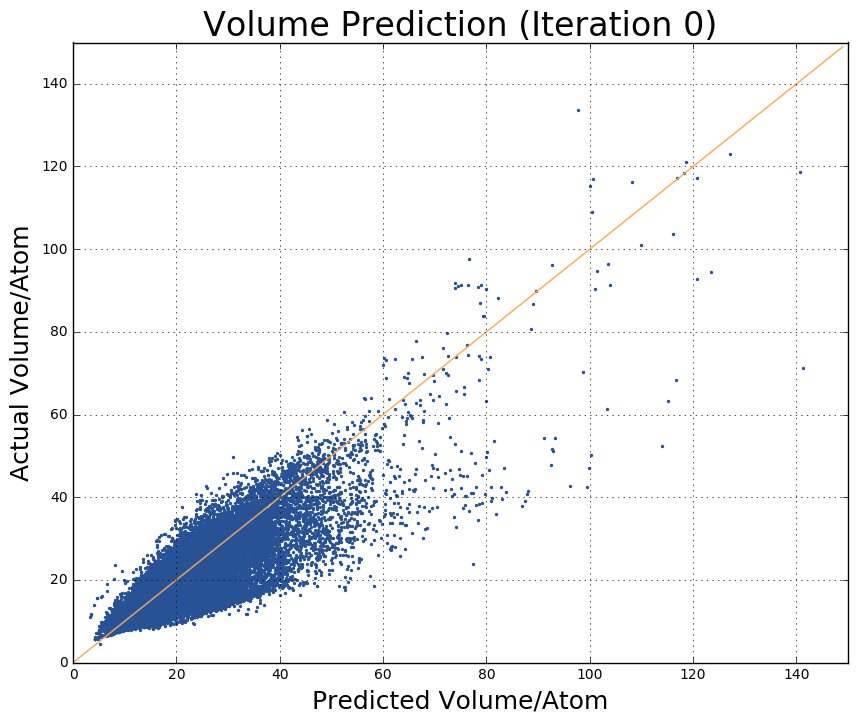

In [205]:
d1 = bl_pred_dfs[0]

x = (d1['predicted_volume']/d1['num_atoms']).tolist()
y = (d1['actual_volume']/d1['num_atoms']).tolist()

a1 = np.arange(150)
a2 = a1*0.8

plt.scatter(x,y,s=2,color='#285296')
plt.plot(range(0,150),range(0,150), '#FFA74D')

plt.xlabel('Predicted Volume/Atom',fontsize=18)
plt.ylabel('Actual Volume/Atom',fontsize=18)
plt.title('Volume Prediction (Iteration 0)',fontsize=24)
axes = plt.gca()
axes.set_xlim([0,150])
axes.set_ylim([0,150])
plt.grid()
plt.show()

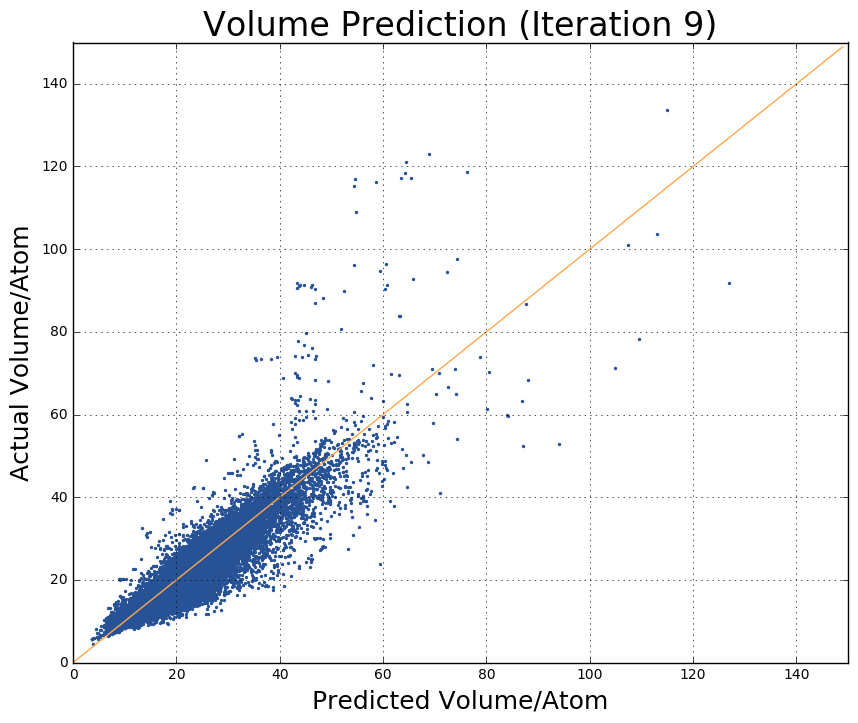

In [198]:
d1 = bl_pred_dfs[-1]

x = (d1['predicted_volume']/d1['num_atoms']).tolist()
y = (d1['actual_volume']/d1['num_atoms']).tolist()

plt.scatter(x,y,s=2,color='#285296')
plt.plot(range(0,150), '#FFA74D')

plt.xlabel('Predicted Volume/Atom',fontsize=18)
plt.ylabel('Actual Volume/Atom',fontsize=18)
plt.title('Volume Prediction (Iteration 9)',fontsize=24)
axes = plt.gca()
axes.set_xlim([0,150])
axes.set_ylim([0,150])
plt.grid()
plt.show()

In [171]:
p = PlotlyFig(x_title='Initial Prediction (sum of atomic radii)', y_title='Final Prediction',
          plot_title='Initial vs Final Predictions', height=600, width=800,
          plot_mode='notebook', margin_left=150, textsize=25,)

p.xy_plot(x_col=x, y_col=y, marker_outline_width=1,
            text=bonds.keys(), 
            add_xy_plot=[{'x_col': [0, 5], 'y_col': [0, 5],
                          'color': 'green', 'mode': 'lines',
                          'legend': None,'text': None, 'size': None},
                        ],)



p = PlotlyFig(x_title='Initial Prediction (sum of atomic radii)', y_title='Final Prediction Delta',
          plot_title='Initial Predictions vs Final Delta', height=600, width=800,
          plot_mode='notebook', margin_left=150, textsize=25,)


p.xy_plot(x_col=x, y_col=z, marker_outline_width=1,
            text=bonds.keys(), 
            add_xy_plot=[{'x_col': [0, 5], 'y_col': [1, 1],
                          'color': 'black', 'mode': 'lines',
                          'legend': None,'text': None, 'size': None},
                         {'x_col': [0, 5], 'y_col': [0, 0],
                          'color': 'black', 'mode': 'lines',
                          'legend': None,'text': None, 'size': None},
                         {'x_col': [0, 5], 'y_col': [-1, -1],
                          'color': 'black', 'mode': 'lines',
                          'legend': None,'text': None, 'size': None}
                        ],
             )

## Analysis

In [38]:
e1 = Element('O')
e2 = Element('Xe')
print e1.atomic_radius, e1.average_ionic_radius
print e2.atomic_radius, e2.average_ionic_radius

0.6 ang 1.26 ang
None 0.62 ang


In [150]:
display_material_data('Ba10P6SO24')

name material_id worst_predicted_bond  expected_distance  \
6194  Ba10P6SO24    mp-16990                  O-P           1.667579   

      actual_distance  predicted_volume  actual_volume  num_atoms  \
6194         1.560596        885.564741     725.826016       41.0   

                           _id     score  
6194  58f01a7c7f079f2488b2f889  0.220079

name material_id worst_predicted_bond  expected_distance  \
6194  Ba10P6SO24    mp-16990                Ba-Ba           4.015541   

      actual_distance  predicted_volume  actual_volume  num_atoms  \
6194          3.87357        808.594267     725.826016       41.0   

                           _id     score  
6194  58f01a7c7f079f2488b2f889  0.114033

name material_id worst_predicted_bond  expected_distance  \
6194  Ba10P6SO24    mp-16990                Ba-Ba           4.015541   

      actual_distance  predicted_volume  actual_volume  num_atoms  \
6194          3.87357        808.594267     725.826016       41.0   

                           _id     score  
6194  58f01a7c7f079f2488b2f889  0.114033

name material_id worst_predicted_bond  expected_distance  \
6194  Ba10P6SO24    mp-16990                Ba-Ba           4.015541   

      actual_distance  predicted_volume  actual_volume  num_atoms  \
6194          3.87357        808.594267     725.826016       41.0   

                           _id     score  
6194  58f01a7c7f079f2488b2f889  0.114033

In [87]:
display_bond_data('O-P')

{'estimates': [1.6516817125230687, 1.5904619492444141],
 'mp_values': {u'mp-1011858': 1.5010249645487905,
               u'mp-1013577': 1.5118169650704953,
               u'mp-1013911': 1.5060446156887568,
               u'mp-1019736': 1.4953152960397593,
               u'mp-18997': 1.5380215851185741,
               u'mp-24452': 1.5212220019614364,
               u'mp-24976': 1.5073971538157973,
               u'mp-26796': 1.5024132748668442,
               u'mp-26851': 1.5446333953057705,
               u'mp-31615': 1.5147854676914743,
               u'mp-31641': 1.482643304225047,
               u'mp-31961': 1.4897768246675103,
               u'mp-31964': 1.49952241569582,
               u'mp-504139': 1.5269268797036748,
               u'mp-504263': 1.515787631704237,
               u'mp-540269': 1.5020964280670632,
               u'mp-540434': 1.4757882948614232,
               u'mp-540475': 1.5533951023282182,
               u'mp-540496': 1.5033967754357922,
               u'mp-54

name material_id worst_predicted_bond  expected_distance  \
11     Mg2Cu2P2(H4O5)3   mp-759001                  O-P           1.645052   
17        Fe3Co2P6WO24   mp-769471                  O-P           1.641465   
41        CaFe3(P2O7)2    mvc-1003                  O-P           1.648682   
48         PH10C3N2O4F   mp-558845                  O-P           1.635945   
57            Li2CuPO4    mp-26851                  O-P           1.665346   
61             MoPCl8O   mp-652001                  O-P           1.625198   
66          Cr2P4H3O16   mp-776748                  O-P           1.642107   
72           Li2SnP2O7   mp-673071                  O-P           1.659816   
74        Ca3Cr3(PO4)4   mp-566617                  O-P           1.657450   
95          EuCs(PO3)4  mp-1019736                  O-P           1.663477   
96             LiSnPO4   mp-753939                  O-P           1.658115   
100           CaP2H6O7    mp-24452                  O-P           1.646523   
105      V3Fe2Te(PO4)6   mp-776747                  O-P           1.644157   
113           CaV2P2O9   mvc-13220                  O-P           1.654291   
126       LiTi2P4H3O16   mp-753653                  O-P           1.648649   
136             LiVPO4   mp-765022                  O-P           1.660882   
149           V3(PO4)2   mp-770844                  O-P           1.649778   
152       Ca10P6ClO24F   mp-686571                  O-P           1.665533   
154        CuP2(H2O3)2   mp-730473                  O-P           1.640665   
157      V3Cr2Ni(PO4)6   mp-791893                  O-P           1.645601   
173         Fe2P4PbO14    mp-24976                  O-P           1.640131   
179           LiMoP2O7   mp-697767                  O-P           1.651235   
188      Ti3V2Ni(PO4)6   mp-780859                  O-P           1.646657   
207            LiMnPO4   mp-780884                  O-P           1.661664   
214      Ti3Mn2V(PO4)6   mp-775444                  O-P           1.647908   
219          Li2NiP2O7   mp-694722                  O-P           1.660026   
220       MnFeCo(PO4)3   mp-764739                  O-P           1.644482   
223            Co2PHO5   mp-541452                  O-P           1.644401   
225         CaMn(PO3)4    mvc-2200                  O-P           1.649114   
237            LiCuPO4   mp-755245                  O-P           1.658560   
250          LiP(WO4)2   mp-763526                  O-P           1.648376   
260         CsGaP3HO10   mp-703308                  O-P           1.651118   
269          PH9C2NO3F   mp-600215                  O-P           1.636877   
296          Fe7(PO4)6   mp-542523                  O-P           1.643939   
318            LiMnPO4   mp-765872                  O-P           1.661664   
330          Fe7(PO5)4   mp-761434                  O-P           1.645056   
335          Li2CoP2O7   mp-778815                  O-P           1.660158   
339           ZnP2H6O5   mp-720739                  O-P           1.640293   
377  Li4TiMn2Ni3(PO4)6   mp-776756                  O-P           1.656613   
381             MoP2O7    mvc-1286                  O-P           1.636380   
386       Mn2Ni3P6WO24   mp-761703                  O-P           1.642944   
404           CaFeP2O7    mvc-6954                  O-P           1.652950   
419          Na2CoP2O7  mp-1013577                  O-P           1.661103   
443           LiFePO4F   mp-771908                  O-P           1.661573   
449        Na2Mn(PO3)5   mp-567904                  O-P           1.653288   
455            LiCrPO4   mp-761391                  O-P           1.660600   
462     Li4Co5(P3O11)2    mp-31615                  O-P           1.655454   
492           LiMoP2O7   mp-540269                  O-P           1.651235   
496         Li4V3P8O29   mp-766667                  O-P           1.653745   
499        Na2LiCuPCO7   mp-776432                  O-P           1.664904   
534         LiCr(PO3)3    mp-31641      

name material_id worst_predicted_bond  expected_distance  \
7           V2Co(PO5)2   mp-559170                  O-P           1.651682   
11     Mg2Cu2P2(H4O5)3   mp-759001                  O-P           1.651682   
17        Fe3Co2P6WO24   mp-769471                  O-P           1.651682   
34         BaMo2(PO4)4   mp-567053                  O-P           1.651682   
35        Fe7Te(PO4)12   mp-777003                  O-P           1.651682   
41        CaFe3(P2O7)2    mvc-1003                  O-P           1.651682   
48         PH10C3N2O4F   mp-558845                  O-P           1.651682   
61             MoPCl8O   mp-652001                  O-P           1.651682   
66          Cr2P4H3O16   mp-776748                  O-P           1.651682   
72           Li2SnP2O7   mp-673071                  O-P           1.651682   
74        Ca3Cr3(PO4)4   mp-566617                  O-P           1.651682   
95          EuCs(PO3)4  mp-1019736                  O-P           1.651682   
96             LiSnPO4   mp-753939                  O-P           1.651682   
100           CaP2H6O7    mp-24452                  O-P           1.651682   
105      V3Fe2Te(PO4)6   mp-776747                  O-P           1.651682   
108            V3P3O13   mvc-10619                  O-P           1.651682   
113           CaV2P2O9   mvc-13220                  O-P           1.651682   
121        LiSn4(PO4)3   mp-765150                  O-P           1.651682   
126       LiTi2P4H3O16   mp-753653                  O-P           1.651682   
136             LiVPO4   mp-765022                  O-P           1.651682   
149           V3(PO4)2   mp-770844                  O-P           1.651682   
152       Ca10P6ClO24F   mp-686571                  O-P           1.651682   
154        CuP2(H2O3)2   mp-730473                  O-P           1.651682   
157      V3Cr2Ni(PO4)6   mp-791893                  O-P           1.651682   
173         Fe2P4PbO14    mp-24976                  O-P           1.651682   
179           LiMoP2O7   mp-697767                  O-P           1.651682   
188      Ti3V2Ni(PO4)6   mp-780859                  O-P           1.651682   
207            LiMnPO4   mp-780884                  O-P           1.651682   
214      Ti3Mn2V(PO4)6   mp-775444                  O-P           1.651682   
219          Li2NiP2O7   mp-694722                  O-P           1.651682   
220       MnFeCo(PO4)3   mp-764739                  O-P           1.651682   
223            Co2PHO5   mp-541452                  O-P           1.651682   
225         CaMn(PO3)4    mvc-2200                  O-P           1.651682   
237            LiCuPO4   mp-755245                  O-P           1.651682   
240            LiCuPO4   mp-759365                  O-P           1.651682   
250          LiP(WO4)2   mp-763526                  O-P           1.651682   
260         CsGaP3HO10   mp-703308                  O-P           1.651682   
269          PH9C2NO3F   mp-600215                  O-P           1.651682   
296          Fe7(PO4)6   mp-542523                  O-P           1.651682   
318            LiMnPO4   mp-765872                  O-P           1.651682   
330          Fe7(PO5)4   mp-761434                  O-P           1.651682   
331           Na3VBPO7   mp-780595                  O-P           1.651682   
335          Li2CoP2O7   mp-778815                  O-P           1.651682   
339           ZnP2H6O5   mp-720739                  O-P           1.651682   
377  Li4TiMn2Ni3(PO4)6   mp-776756                  O-P           1.651682   
381             MoP2O7    mvc-1286                  O-P           1.651682   
384  Li12CoNi3P4(CO7)4   mp-767857                  O-P           1.651682   
386       Mn2Ni3P6WO24   mp-761703                  O-P           1.651682   
404           CaFeP2O7    mvc-6954                  O-P           1.651682   
419          Na2CoP2O7  mp-1013577                  O-P           1.651682   
437            LiCrPO4   mp-761388      

name material_id worst_predicted_bond  expected_distance  \
7           V2Co(PO5)2   mp-559170                  O-P           1.590462   
11     Mg2Cu2P2(H4O5)3   mp-759001                  O-P           1.590462   
34         BaMo2(PO4)4   mp-567053                  O-P           1.590462   
35        Fe7Te(PO4)12   mp-777003                  O-P           1.590462   
41        CaFe3(P2O7)2    mvc-1003                  O-P           1.590462   
48         PH10C3N2O4F   mp-558845                  O-P           1.590462   
61             MoPCl8O   mp-652001                  O-P           1.590462   
72           Li2SnP2O7   mp-673071                  O-P           1.590462   
74        Ca3Cr3(PO4)4   mp-566617                  O-P           1.590462   
95          EuCs(PO3)4  mp-1019736                  O-P           1.590462   
96             LiSnPO4   mp-753939                  O-P           1.590462   
100           CaP2H6O7    mp-24452                  O-P           1.590462   
105      V3Fe2Te(PO4)6   mp-776747                  O-P           1.590462   
108            V3P3O13   mvc-10619                  O-P           1.590462   
113           CaV2P2O9   mvc-13220                  O-P           1.590462   
121        LiSn4(PO4)3   mp-765150                  O-P           1.590462   
126       LiTi2P4H3O16   mp-753653                  O-P           1.590462   
136             LiVPO4   mp-765022                  O-P           1.590462   
149           V3(PO4)2   mp-770844                  O-P           1.590462   
152       Ca10P6ClO24F   mp-686571                  O-P           1.590462   
154        CuP2(H2O3)2   mp-730473                  O-P           1.590462   
157      V3Cr2Ni(PO4)6   mp-791893                  O-P           1.590462   
173         Fe2P4PbO14    mp-24976                  O-P           1.590462   
179           LiMoP2O7   mp-697767                  O-P           1.590462   
188      Ti3V2Ni(PO4)6   mp-780859                  O-P           1.590462   
207            LiMnPO4   mp-780884                  O-P           1.590462   
214      Ti3Mn2V(PO4)6   mp-775444                  O-P           1.590462   
219          Li2NiP2O7   mp-694722                  O-P           1.590462   
225         CaMn(PO3)4    mvc-2200                  O-P           1.590462   
237            LiCuPO4   mp-755245                  O-P           1.590462   
260         CsGaP3HO10   mp-703308                  O-P           1.590462   
269          PH9C2NO3F   mp-600215                  O-P           1.590462   
318            LiMnPO4   mp-765872                  O-P           1.590462   
335          Li2CoP2O7   mp-778815                  O-P           1.590462   
339           ZnP2H6O5   mp-720739                  O-P           1.590462   
377  Li4TiMn2Ni3(PO4)6   mp-776756                  O-P           1.590462   
381             MoP2O7    mvc-1286                  O-P           1.590462   
386       Mn2Ni3P6WO24   mp-761703                  O-P           1.590462   
404           CaFeP2O7    mvc-6954                  O-P           1.590462   
419          Na2CoP2O7  mp-1013577                  O-P           1.590462   
437            LiCrPO4   mp-761388                  O-P           1.590462   
449        Na2Mn(PO3)5   mp-567904                  O-P           1.590462   
455            LiCrPO4   mp-761391                  O-P           1.590462   
462     Li4Co5(P3O11)2    mp-31615                  O-P           1.590462   
492           LiMoP2O7   mp-540269                  O-P           1.590462   
496         Li4V3P8O29   mp-766667                  O-P           1.590462   
534         LiCr(PO3)3    mp-31641                  O-P           1.590462   
555          LiVP3HO10   mp-774404                  O-P           1.590462   
569       Li3Cu3(PO4)2   mp-754308                  O-P           1.590462   
576           MnZnP2O7    mvc-6958                  O-P           1.590462   
605            NaCuPO4   mp-581303      

name material_id worst_predicted_bond  expected_distance  \
7           V2Co(PO5)2   mp-559170                  O-P           1.590462   
11     Mg2Cu2P2(H4O5)3   mp-759001                  O-P           1.590462   
34         BaMo2(PO4)4   mp-567053                  O-P           1.590462   
35        Fe7Te(PO4)12   mp-777003                  O-P           1.590462   
41        CaFe3(P2O7)2    mvc-1003                  O-P           1.590462   
48         PH10C3N2O4F   mp-558845                  O-P           1.590462   
61             MoPCl8O   mp-652001                  O-P           1.590462   
66          Cr2P4H3O16   mp-776748                  O-P           1.590462   
72           Li2SnP2O7   mp-673071                  O-P           1.590462   
74        Ca3Cr3(PO4)4   mp-566617                  O-P           1.590462   
95          EuCs(PO3)4  mp-1019736                  O-P           1.590462   
96             LiSnPO4   mp-753939                  O-P           1.590462   
100           CaP2H6O7    mp-24452                  O-P           1.590462   
105      V3Fe2Te(PO4)6   mp-776747                  O-P           1.590462   
108            V3P3O13   mvc-10619                  O-P           1.590462   
113           CaV2P2O9   mvc-13220                  O-P           1.590462   
121        LiSn4(PO4)3   mp-765150                  O-P           1.590462   
126       LiTi2P4H3O16   mp-753653                  O-P           1.590462   
136             LiVPO4   mp-765022                  O-P           1.590462   
149           V3(PO4)2   mp-770844                  O-P           1.590462   
152       Ca10P6ClO24F   mp-686571                  O-P           1.590462   
154        CuP2(H2O3)2   mp-730473                  O-P           1.590462   
157      V3Cr2Ni(PO4)6   mp-791893                  O-P           1.590462   
173         Fe2P4PbO14    mp-24976                  O-P           1.590462   
179           LiMoP2O7   mp-697767                  O-P           1.590462   
188      Ti3V2Ni(PO4)6   mp-780859                  O-P           1.590462   
207            LiMnPO4   mp-780884                  O-P           1.590462   
214      Ti3Mn2V(PO4)6   mp-775444                  O-P           1.590462   
219          Li2NiP2O7   mp-694722                  O-P           1.590462   
225         CaMn(PO3)4    mvc-2200                  O-P           1.590462   
237            LiCuPO4   mp-755245                  O-P           1.590462   
260         CsGaP3HO10   mp-703308                  O-P           1.590462   
269          PH9C2NO3F   mp-600215                  O-P           1.590462   
318            LiMnPO4   mp-765872                  O-P           1.590462   
335          Li2CoP2O7   mp-778815                  O-P           1.590462   
339           ZnP2H6O5   mp-720739                  O-P           1.590462   
377  Li4TiMn2Ni3(PO4)6   mp-776756                  O-P           1.590462   
381             MoP2O7    mvc-1286                  O-P           1.590462   
384  Li12CoNi3P4(CO7)4   mp-767857                  O-P           1.590462   
386       Mn2Ni3P6WO24   mp-761703                  O-P           1.590462   
404           CaFeP2O7    mvc-6954                  O-P           1.590462   
419          Na2CoP2O7  mp-1013577                  O-P           1.590462   
437            LiCrPO4   mp-761388                  O-P           1.590462   
449        Na2Mn(PO3)5   mp-567904                  O-P           1.590462   
455            LiCrPO4   mp-761391                  O-P           1.590462   
462     Li4Co5(P3O11)2    mp-31615                  O-P           1.590462   
492           LiMoP2O7   mp-540269                  O-P           1.590462   
496         Li4V3P8O29   mp-766667                  O-P           1.590462   
534         LiCr(PO3)3    mp-31641                  O-P           1.590462   
555          LiVP3HO10   mp-774404                  O-P           1.590462   
569       Li3Cu3(PO4)2   mp-754308      

### getting the coefficients of variance of MP data - shows how spread the bond lengths are

In [152]:
test_df_data = []
for b in bonds:
    x = bonds[b]['mp_values'].values()
    test_df_data.append({'bond_name':b, 'CV': np.std(x)/np.mean(x), 'std_dev':np.std(x), 'mean':np.mean(x),
                         'variance':np.var(x)})

bond_cv_scores = pd.DataFrame(test_df_data)
display(bond_cv_scores.sort_values('CV',ascending=False).head(25))

CV bond_name      mean   std_dev  variance
574   0.122630     Pu-Pu  3.116707  0.382202  0.146078
2286  0.112965     Ba-Rb  4.248435  0.479924  0.230327
1931  0.102770     Np-Np  3.227282  0.331669  0.110004
825   0.101429     Li-Li  2.398529  0.243281  0.059186
1289  0.098125      K-Sr  3.974719  0.390020  0.152115
1640  0.097307      Np-O  1.958500  0.190575  0.036319
2379  0.096138     Rb-Rb  3.949153  0.379663  0.144144
328   0.095998       U-U  3.034870  0.291343  0.084881
307   0.095431     Cs-Cs  4.271954  0.407676  0.166200
2037  0.095343      S-Se  2.387792  0.227659  0.051829
755   0.092994       K-K  3.694344  0.343553  0.118028
509   0.092128     Br-Tl  2.799242  0.257890  0.066507
704   0.091723     Hg-Hg  2.814320  0.258137  0.066635
2296  0.090590     Ce-Ru  2.684296  0.243170  0.059132
1748  0.087439      Fe-U  2.580126  0.225603  0.050897
1474  0.087243     Fe-La  2.821365  0.246144  0.060587
1378  0.086859     Na-Na  3.031510  0.263315  0.069335
160   0.086275     Ir-Pr  2.851304  0.245996  0.060514
1085  0.085652     Na-Rb  3.524098  0.301847  0.091112
1408  0.083923     Cl-Tl  2.626941  0.220461  0.048603
2370  0.083913     Li-Sr  3.041480  0.255219  0.065137
1078  0.080856      Cr-O  1.833387  0.148241  0.021975
189   0.080684       O-O  1.354905  0.109320  0.011951
1958  0.080143      O-Pu  2.214475  0.177475  0.031497
1108  0.079519     Rb-Sr  4.152111  0.330171  0.109013